## Generating hypergraphs using random models

This tutorial and all supporting code were developed by Mirah Shi, Sinan Aksoy, and Nicholas Landry.

Implementation of and tutorial using two hypergraph generative models: 
1. [Erdös–Rényi](#erdosrenyi)
2. [Chung-Lu](#chunglu)

Hypergraph Erdös–Rényi and Chung-Lu implementations are described in

> S. Aksoy, T.G. Kolda, and A. Pinar. Measuring and modeling bipartite graphs with community struc-ture. In:Journal of Complex Networks 5.4 (Mar. 2017), pp. 581–603.

and adapt the algorithm in

> J. C. Miller and A. Hagberg. Efficient generation of networks with given expected degrees. In 8th International
Conference on Algorithms and Models for the Web Graph (2011), pp. 115–126.

<img src='images/genmodels_hypergraph.png' width='200px' style="float:left;margin-right:10pt"></img>

Generative models are useful tools in network science for their ability to approximate real data. Datasets are typically of a fixed size and generative models allow us to create networks with similar properties, but of arbitrary size. These models can be used as a proxy when the real data may too sensitive to reveal. Lastly, we can use generative models for *inference*, where given a real network and a generative model, we can calculate which parameters best match the given data. We can extend these network science ideas to networks where interactions can happen between greater than two entities.

In [1]:
import random
import matplotlib.pyplot as plt
import time
from collections import Counter

import hypernetx as hnx
import hypernetx.algorithms.generative_models as gm

import shutup
shutup.mute_warnings()

## Erdös–Rényi Hypergraphs <a id="erdosrenyi"></a>

<img src='images/erdosrenyi.png' width='200px' style="float:left;margin-right:10pt"></img>


In the article [Measuring and modeling bipartite graphs with community structure](https://doi.org/10.1093/comnet/cnx001) by Aksoy et al., they define the bipartite version of the network Erdös–Rényi model. Any bipartite network can be expressed as a hypergraph if one layer is defined as the nodes and the other layer is defined as the edges. We developed an efficient algorithm based on the [Miller-Hagberg approach](https://doi.org/10.1007/978-3-642-21286-4_10) that runs in $O(N+M)$ complexity by drawing from a geometric distribution instead of the naive algorithm that runs in $O(NM)$ time by iterating through every combination and performing a weighted coin-flip.

In [2]:
n = 1000
m = n
p = 0.01

# generate ER hypergraph
H = gm.erdos_renyi_hypergraph(n, m, p)

Calculate the number of expected and generated vertex-hyperedge pairs

In [3]:
print('Expected # pairs: ', int(n*m*p))
print('Output # pairs: ', H.incidence_matrix().count_nonzero())

Expected # pairs:  10000
Output # pairs:  9975


## Chung-Lu Hypergraph <a id="chunglu"></a>

<img src='images/chunglu.png' width='200px' style="float:left;margin-right:10pt"></img>

Also in the article [Measuring and modeling bipartite graphs with community structure](https://doi.org/10.1093/comnet/cnx001) by Aksoy et al., they define the bipartite version of the network Chung-Lu model. Like before, we can generate a bipartite network and define one layer as the nodes and the other layer as the edges. We developed an efficient algorithm based on the [Miller-Hagberg approach](https://doi.org/10.1007/978-3-642-21286-4_10) that runs in $O(N+M)$ complexity instead of the naive algorithm that runs in $O(NM)$ time. Unlike the Erdös–Rényi case, in the Chung-Lu model, the probabilities vary by degree, so in addition to drawing from a geometric distribution, we sort the degrees in reverse order and perform rejection sampling.

The Chung-Lu model fulfills a degree distribution in expectation. Given degree distributions $W_n=\{w_1^v,...,w_n^v\}, W_m=\{w_1^e,...,w_m^e\}$ for vertices and hyperedges respectively, the hypergraph Chung-Lu model assigns vertex $i$ to hyperedge $j$ with probability $$p_{ij}=\frac{w_i^v w_j^e}{S},$$ where $$S=\sum_{i=1}^n w_i^v=\sum_{j=1}^m w_j^e$$

### Example hypergraph

We use a preprocessed disease-gene dataset (available from https://www.disgenet.org/downloads) and create a hypergraph with genes as vertices and diseases as hyperedges. Then we extract the degree sequences as input to ``chung_lu_hypergraph``.

In [4]:
gene_data = hnx.utils.toys.GeneData()
genes = gene_data.genes
diseases = gene_data.diseases
disease_gene_network = gene_data.disease_gene_network
print('Number of vertices: ', len(genes))
print('Number of hyperedges: ', len(diseases))

Number of vertices:  12368
Number of hyperedges:  2261


### Construct degree sequences

Label vertices and hyperedges with their desired degree:

In [5]:
k1 = {n: d for n, d in disease_gene_network.degree() if n in genes}
k2 = {n: d for n, d in disease_gene_network.degree() if n in diseases}

### Create Chung-Lu hypergraph

``chung_lu_hypergraph`` generates a bipartite edge list, or equivalently, a list of vertex-hyperedge pairs and outputs it as a HyperNetX object.

In [6]:
H = gm.chung_lu_hypergraph(k1, k2)

### Visualize results

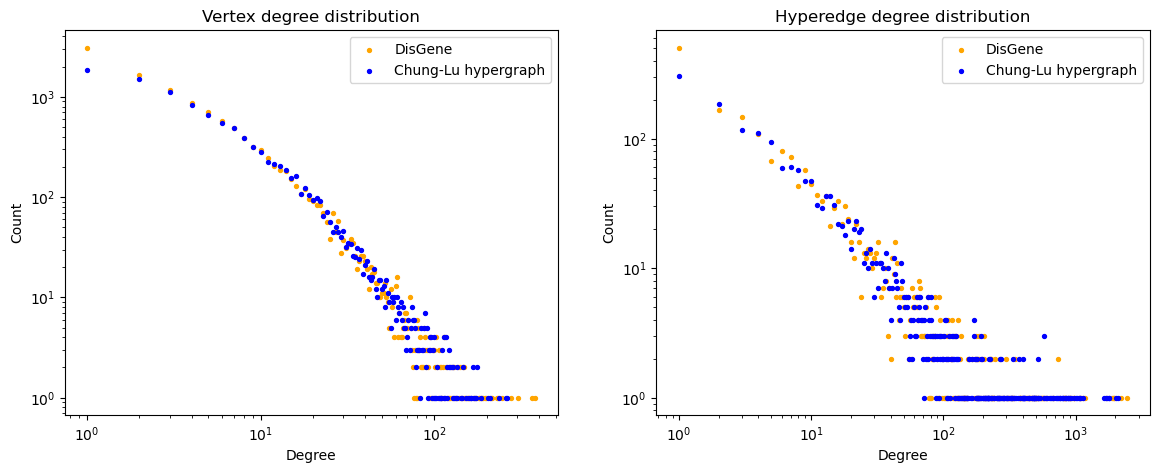

In [7]:

# plot desired vs output degree distribution
node_degrees = [H.degree(node) for node in H.nodes]
edge_degrees = H.edge_size_dist()

fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].scatter(Counter(k1.values()).keys(), Counter(k1.values()).values(), color='orange', s=8, label='DisGene')
ax[0].scatter(Counter(node_degrees).keys(), Counter(node_degrees).values(), color='blue', s=8, label='Chung-Lu hypergraph')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Count')
ax[0].set_title('Vertex degree distribution')
ax[0].legend(loc='best')

ax[1].scatter(Counter(k2.values()).keys(), Counter(k2.values()).values(), color='orange', s=8, label='DisGene')
ax[1].scatter(Counter(edge_degrees).keys(), Counter(edge_degrees).values(), color='blue', s=8, label='Chung-Lu hypergraph')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel('Count')
ax[1].set_title('Hyperedge degree distribution')
ax[1].legend(loc='best')
plt.show()

As we can see, the Chung-Lu model does not match the degree distribution exactly (notice the small tail of the distribution of actual degrees in contrast to the desired degree distribution)

This algorithm, as mentioned before, has linear time complexity $O(N+M)$. We can test this out by plotting the hypergraph generation time with respect to $N+M$.

In [8]:

n = [500, 500, 500, 1000, 1000, 1000]
m = [100, 500, 1000, 1000, 5000, 10000]
m_and_n = list()
generation_time = list()

for i in range(len(n)):
    k1 = {j : random.randint(1, 10) for j in range(n[i])}
    k2 = {j : random.randint(1, 10) for j in range(m[i])}

    m_and_n.append(n[i] + m[i])

    start = time.time()    
    H = gm.chung_lu_hypergraph(k1, k2)
    generation_time.append(time.time() - start)



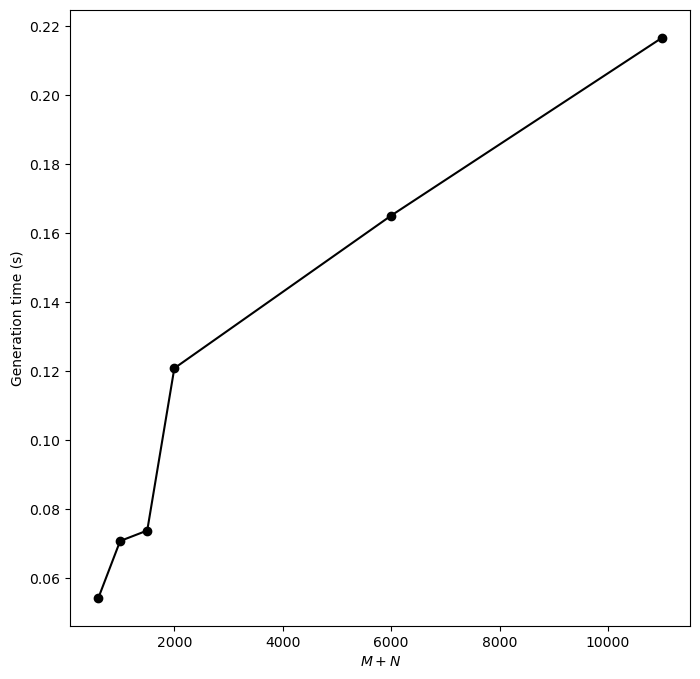

In [9]:
plt.plot(m_and_n, generation_time, 'ko-')
plt.xlabel(r"$M+N$")
plt.ylabel("Generation time (s)")
plt.show()

From the plot, we can see (sans artifacts for small $M+N$) that there is a roughly linear relationship as we predicted.